---
# Previsão de Séries Temporais do Preço do Boi Gordo CEPEA/B3
---

Este é um trabalho de previsão de séries temporais agrícolas mais especificamente de indicadores de preços pecuários do Boi Gordo e Bezerro mensais. Ambas séries foram coletadas e podem ser encontradas facilmente do site da [CEPEA - Centro de Estudos Avançados em Economia Aplicada](https://www.cepea.esalq.usp.br/br).

A série referente aos preços do Boi Gordo é o principal indicador usado como base para criação e formação de preços para os contratos futuros do Boi Gordo da [B3](http://www.b3.com.br/pt_br/). Sobre a metólogia usada para criação deste indicador é feita uma média dos preços da arroba do boi gordo de todas as regiões do estado de São Paulo. Para poder encontrar mais informações referentes a métodologia utilizada para criação deste indicador acesse este [link](https://www.cepea.esalq.usp.br/upload/kceditor/files/Cepea_B3_Metodologia_Indicador_BOI_02_01_2020.pdf).

In [1]:
# carregando as bibliotecas utilizadas

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools

# Imports para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
from plotly.figure_factory import create_distplot

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import pmdarima as pm
from pandas.plotting import autocorrelation_plot
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Filtrando os avisos
import sys
import warnings
warnings.filterwarnings("ignore")

# Configurando o estilo de gráfico utilizado
%matplotlib inline
plt.rcParams["figure.figsize"] = 20, 10
plt.style.use('fivethirtyeight')

In [2]:
# Carrega as séries históricas de preços do Boi Gordo-SP e Bezerro-MS
bg = pd.read_csv('Boi-Gordo-SP-B3.csv', header=3)

Após carregados os dados referente as duas séries podemos ver as cinco primeiras linhas do conjunto de dados e também algumas informações referentes ao formato que eles estão.

In [3]:
# Checa as primeiras linhas da série contendo os preços do Boi Gordo
bg.head()

Data À vista R$ À vista US$
0  23/07/1997      26,67       24,65
1  24/07/1997      26,67       24,65
2  25/07/1997      26,71       24,68
3  28/07/1997      26,74        24,7
4  29/07/1997      26,77       24,72

In [4]:
# Checa as informações sobre o tipo de dados da série do Boi Gordo
bg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5675 entries, 0 to 5674
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Data         5675 non-null   object
 1   À vista R$   5675 non-null   object
 2   À vista US$  5675 non-null   object
dtypes: object(3)
memory usage: 133.1+ KB


Como o pandas não reconhece valores dos preços que estão são separados com "," ao invez de ".", teremos que relizar esta substituição além de converter o tipo de dados para o formato "float64" para facilitar a análise que será feita adiante.

In [5]:
# Substituindo a virgulo por ponto das séries

# Boi Gordo - SP
bg['À vista R$'] = bg['À vista R$'].apply(lambda x: str(x).replace(',', '.'))
bg['À vista R$'] = bg['À vista R$'].astype('float64')

Quanto a data das duas séries, essas terão que ser transformadas em para o tipo **"datetime"** do pandas para e também se tornarão o índice do conjunto de dados, isso é feito para que possa tornar mais fácil a manipulação dos dados.

In [6]:
# Alterando o tipo do índice

# Boi Gordo - SP
bg['Data'] = pd.to_datetime(bg['Data'], infer_datetime_format=True)

In [7]:
# Colocando a data como índice

# Boi Gordo - SP
bg = bg.set_index('Data')

Nos dois conjunto de dados retirados da CEPEA/ESALQ, vieram com uma coluna com os valores relativos da arroba do boi gordo e do bezerro em Dollar US$.

Para esta análise, será feita apenas para os valores em Reais R$, portanto vamos excluir a coluna referente aos preços em Dollar de ambos os conjunto de dados.

In [8]:
# Excluindo valores em Dollar US$
bg.drop('À vista US$', axis=1, inplace=True)

Agora que os conjuntos de dados já estão organizados, vamos partir para a fase de análise exploratória do conjunto. 

Para se manter uma ordem, vamos realizar primeiro a análise completa e previsão dos preços do boi gordo, em seguida realizar a análise do conjunto de dados do bezerro e, por fim, realizar a previsões com os modelos. Logo de início, vamos vizualizar a evulação dos preços do Boi Gordo - SP.

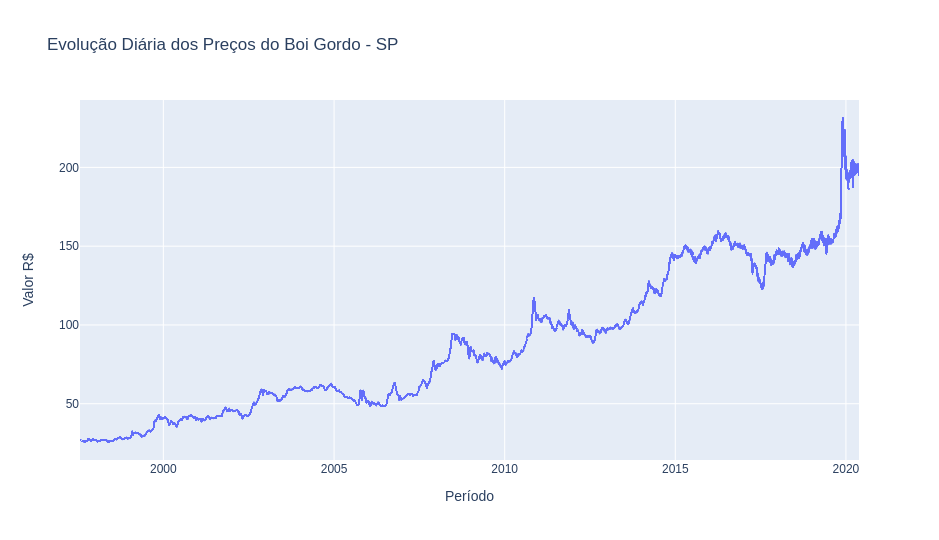

In [9]:
# Evolução dos preços do Boi Gordo - SP
fig = px.line(bg, 
              x=bg.index, 
              y='À vista R$', 
              title='Evolução Diária dos Preços do Boi Gordo - SP')

# Define o layout
fig.update_layout(xaxis_title="Período",
                  yaxis_title="Valor R$",
                  width=950, 
                  height=540)
    
fig.show()

Com base no gráfico acima podemos engergar que os preços para arroba do boi gordo seguem uma tendência de alta desde da criação deste indicador, passando apenas por pequenas quedas e em seguida retornando a sua tendência ascendente original. Tal padrão além de indicar uma tendência de alta nos preços, também apresenta certo grau de sazonalidade em algumas épocas do ano.

O nosso objetivo é realizar a previsão com base no preço médio mensal, por isso vamos realizar tal transformação  e prosseguir com a análise exploratória dos preços.

In [10]:
# Pegando os valores médios mensais dos preços do Boi Gordo
bg = bg['À vista R$'].resample('M').mean()

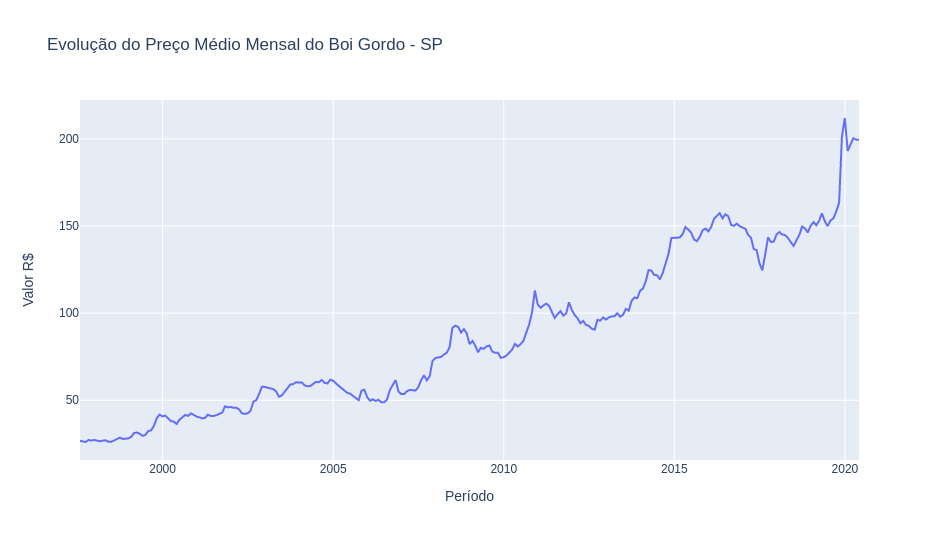

In [11]:
# Evolução dos preços do Boi Gordo - SP
fig = px.line(bg, 
              x=bg.index, 
              y='À vista R$', 
              title='Evolução do Preço Médio Mensal do Boi Gordo - SP')

# Define o layout
fig.update_layout(xaxis_title="Período",
                  yaxis_title="Valor R$",
                  width=950, 
                  height=540)

fig.show()

Com os preços médio, fica mais claro a visualização da tendência ascendente do preço da arroba do boi gordo. Dando continuidade na análise exploratória, vamos checar a distribuição dos preços médio mensais para tentar descobrir algum padrão nos dados.

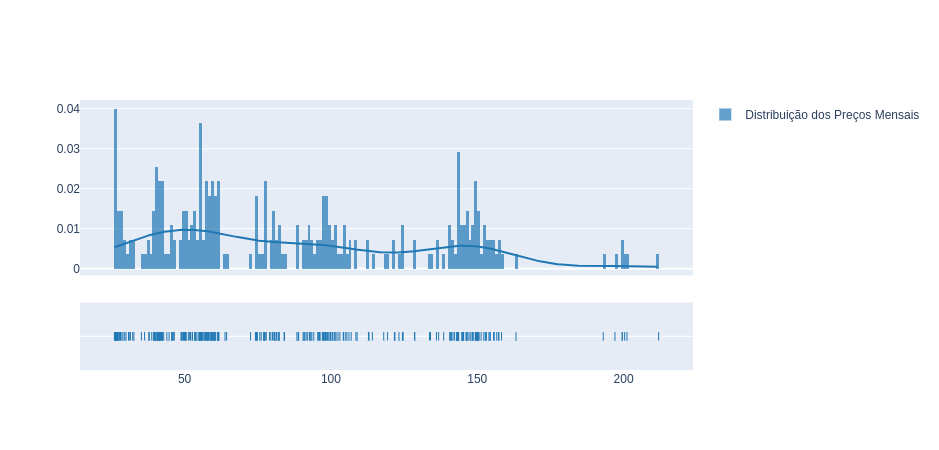

In [12]:
# Histograma e Distplot do preço do Boi Gordo
fig = create_distplot([bg], ['Distribuição dos Preços Mensais'])
fig.show()

Pela distribuição dos preços médios nao conseguimos encontrar qualquer padrão aparente que possamos análisar com mais cuidado. Para tentar entender mais o preço médio da arroba do boi gordo vamos olhar para mais dois outros gráficos o boxplot e violin plot para obter mais informações, porém dessa vez com um olhar sobre possíveis **"outliers"** (preços que estão muito fora do padrão). 

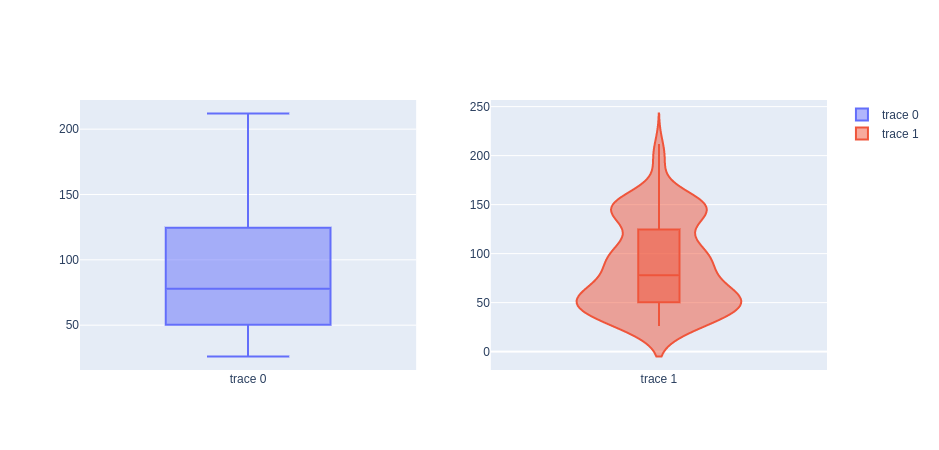

In [13]:
# Checando os outliers por meio do Boxplot e violin plot

# Criando os subplots
fig = make_subplots(rows=1, cols=2)

# Box plot dos preços da arroba do boi gordo
fig.add_trace(go.Box(y=bg), row=1, col=1)

# Violin plot dos preços da arroba do boi gordo
fig.add_trace(go.Violin(y=bg, box_visible=True), row=1, col=2)

# Mostra os gráficos
fig.show()

Além das medidas de tendência central que são mostradas ao longo dos dois gráficos, fica dificíl enxergar algum padrão que não seja a tendência ascendente dos preços. Porém, e se tentássemos olhar para esses gráficos diminuindo a sua granularidade.

Nos dois graficos a seguir vamos checar os box plots para cada ano da série histórica seguido por um boxplot para tentar ver o comportamento dos preços de mês a mês a cada ano.

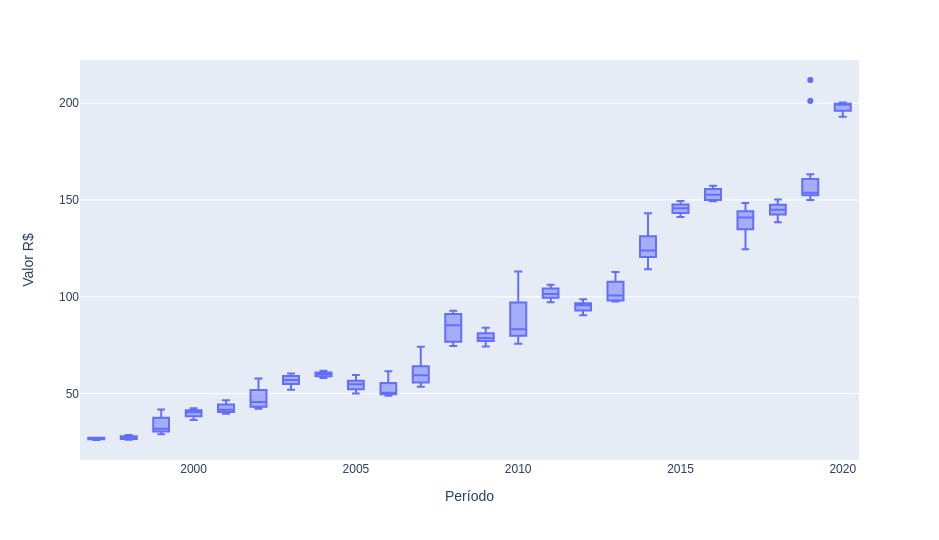

In [14]:
# Box plot para cada ano presente na série histórica

# Cria o gráfico
fig = px.box(bg, 
             x=bg.index.year, 
             y=bg)

# Define o layout
fig.update_layout(xaxis_title="Período",
                  yaxis_title="Valor R$",
                  width=950, 
                  height=540)

# Mostra o gráfico
fig.show()

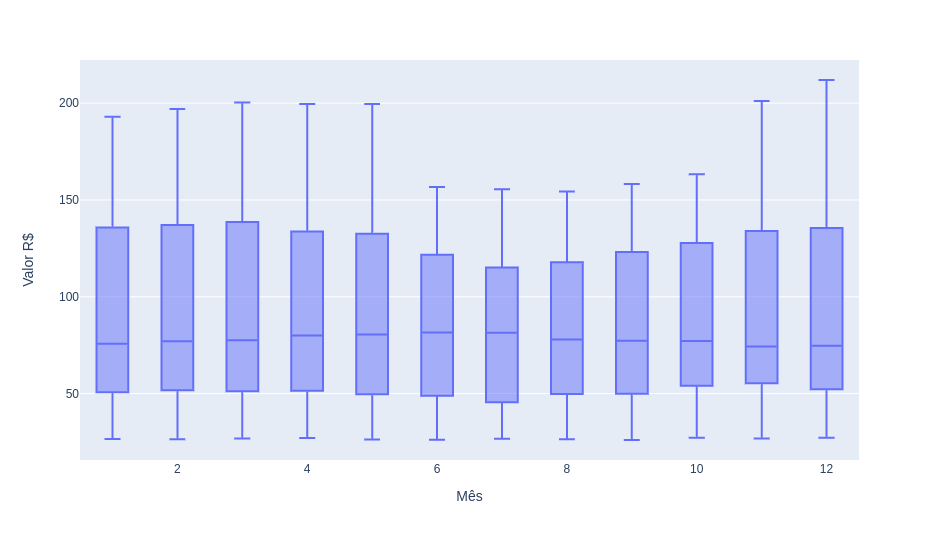

In [15]:
# Box plot para cada mês presente na série histórica

# Cria o gráfico
fig = px.box(bg, 
             x=bg.index.month, 
             y=bg)

# Define o layout
fig.update_layout(xaxis_title="Mês",
                  yaxis_title="Valor R$",
                  width=950, 
                  height=540)

# Mostra o gráfico
fig.show()

Por meio do último gráfico podemos notar que os preços médio relativos aos meses de junho a outubro são menores do que os demais. Sendo assim, poderiam ser esses meses os melhores para a compra do boi gordo? .

Agora que análise exploratória esta terminada, vamos realizar a decomposição da série histórica dos preços do boi gordo. O objetivo da decomposição de séries temporais é aumentar nossa compreensão dos dados, onde dividimos as séries em vários componentes. Isso irá nos fornecer informações em termos de complexidade de modelagem e quais abordagens devem ser seguidas para capturar com precisão cada um dos componentes. 

Esses componentes podem ser divididos em dois tipos: sistemático e não sistemático. Os sistemáticos são caracterizados pela consistência e pelo fato de poderem ser descritos e modelados. Por outro lado, os não sistemáticos não podem ser modelados diretamente.

A seguir estão os componentes sistemáticos:

* **nível**: o valor médio da série;
* **tendência**: uma estimativa da tendência, ou seja, a mudança de valor entre sucessivas pontos de tempo a qualquer momento. Pode ser associado à inclinação(crescente/decrescente) da série;
* **sazonalidade**: Desvios da média causada pela repetição de ciclos de curto prazo.

O seguinte é o componente não sistemático:

* **ruído**: A variação aleatória na série.

Existem dois tipos de modelos usados para decompor séries temporais: **aditivo** e **multiplicativo**. 

A seguir, são apresentadas as características do modelo aditivo:
* Forma do modelo: $y_t = nível + tendência + sazonalidade + ruído$;
* Modelo linear: as mudanças ao longo do tempo são consistentes em tamanho; 
* A tendência é linear (reta);
* Sazonalidade linear com a mesma frequência (largura) e amplitude (altura) dos ciclos ao longo do tempo. 

A seguir, são apresentadas as características do modelo multiplicativo: 
* Forma do modelo: $y_t = nível * tendência * sazonalidade * ruído$;
* Modelo não linear: as mudanças ao longo do tempo não são consistentes em tamanho, por exemplo, tendência exponencial;
* A não curva linear;
* Sazonalidade não linear com frequência crescente/decrescente e amplitude de ciclos ao longo do tempo;

Um modelo multiplicativo é mais apropriado para esta série pois a mesma parece aumentar os valores a uma taxa não linear.

In [16]:
# Cria uma função para Decomposição da série temporal
def series_decompose(serie):
    
    # Decomposição sazonal
    decomposition = seasonal_decompose(serie, model='multiplicative', period=12)
    
    # Cria os subplots
    fig = make_subplots(rows=4, cols=1)
    
    # Cria os gráficos de linhas para cada componente da série de preços
    fig.append_trace(go.Scatter(x=serie.index, y=decomposition.observed, name='Observado'), row=1, col=1)
    fig.append_trace(go.Scatter(x=serie.index, y=decomposition.trend, name='Tendência'), row=2, col=1)
    fig.append_trace(go.Scatter(x=serie.index, y=decomposition.seasonal, name='Sazonalidade'), row=3, col=1)
    fig.append_trace(go.Scatter(x=serie.index, y=decomposition.resid, name='Ruido'), row=4, col=1)
    
    # Define o layout
    fig.update_layout(width=900, height=540)
    # Mostra o gráfico
    fig.show()

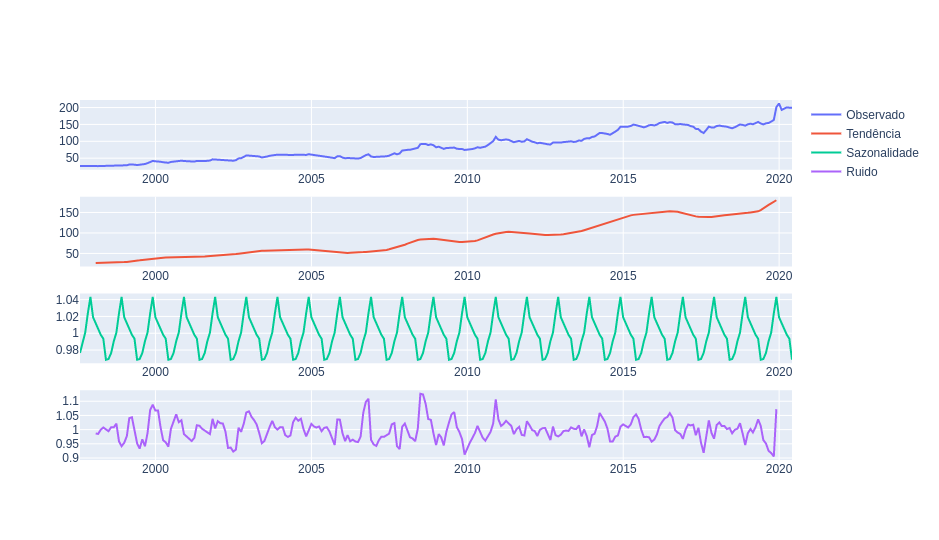

In [17]:
series_decompose(bg)

Com a decomposição mostrada acima fica muito mais claro enxergar a tendência ascedente dos preços da arroba do boi gordo. Já a sazonalidade fica evidente que os preços tendem a ter um patamar durante maio, depois passam a subir até novembro e posteriormente passando a decair a partir de dezembro até maio do próximo ano.

Para mostrar que esta decomposição faz sentido, podemos observar o componente **ruido**. Se este não apresentar um padrão discernível o ajuste faz sentido, em outras palavras, o componente aleatório é realmente aleatório. 

Uma série temporal estacionária é uma série em que propriedades estatísticas como média, variância e a autocorrelação são constantes ao longo do tempo. A estacionariedade é uma característica desejada das séries temporais, pois torna mais viável a modelagem e extrapolação (previsão) para o futuro.

**Média Constante**

Uma série estacionária tem média constante durante o tempo, não existe tendências de alta ou de baixa. A razão disso é que tendo uma média constante com variações ao redor desta média fica muito mais fácil de extrapolar ao futuro.

**Variância Constante**
Quando a série tem variância constante, temos ideia da variação padrão em relação à média, quando a variância não é constante a previsão provavelmente vai ter erros maiores em determinados períodos e estes períodos não serão previsíveis, pois nestes casos espera-se que a variância permaneça inconstante durante o tempo, inclusive no futuro.

**Série Autocorrelacionada**
Em uma série temporal, não há como desconsiderar a estrutura de dependência das observações. Quando duas variáveis tem variação semelhante em relação ao desvio padrão pode-se dizer que as variáveis são correlacionadas.

Por exemplo, a quantidade vendida de sorvete em janeiro pode estar relacionada à quantidade vendida em dezembro, que por sua vez pode estar relacionada com a de novembro e assim por diante. Dessa forma, a utilização desses modelos pode gerar resultados enviesados e que não refletem a realidade.

**A autocorrelação é definida como uma observação num determinado instante está relacionada às observações passadas**. A autocorrelação é uma ferramenta matemática para encontrar padrões de repetição, como a presença de um sinal periódico obscurecidos pelo ruído. Um diagrama de autocorrelações apresenta os valores de autocorrelação de uma amostra versus o intervalo de tempo em que foi calculado. Autocorrelações devem ser próximas de zero para aleatoriedade. **A ocorrência de não estacionariedade é denotada pela lenta queda da ACF nos primeiros lags da série**. Isto significa que a série deve ser diferenciada, e que um modelo **ARIMA** ou **SARIMA** deve ser aplicado.

A identificação da autocorrelação é feita através da **Função de Autocorrelação** (**ACF – Autocorrelation Function**), mostrada abaixo. Além disso, testes como o de **Durbin Watson** auxiliam na identificação da autocorrelação de primeira ordem.

In [18]:
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=serie.index, y=serie, mode='lines', name='Preços'))
    fig.add_trace(go.Scatter(x=rolmean.index, y=rolmean, mode='lines', name='Média'))
    fig.add_trace(go.Scatter(x=rolstd.index, y=rolstd, mode='lines', name='Desvio Padrão'))
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    adfuller_test = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    adfuller_saida = pd.Series(adfuller_test[0:4], index = ['Estatística do Teste',
                                                            'Valor-p',
                                                            'Número de Lags Consideradas',
                                                            'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in adfuller_test[4].items():
        adfuller_saida['Valor Crítico (%s)'%key] = value

    # Print
    print (adfuller_saida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if adfuller_saida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')
        
    
    # Teste KPSS:
    # Print
    print('\nResultado do KPPS:\n')

    # Teste
    kpss_test = kpss(serie)

    # Formatando a saída
    kpss_saida = pd.Series(kpss_test[0:3], index = ['Estatística do Teste',
                                                    'Valor-p',
                                                    'Número de Lags Consideradas'])

    # Loop por cada item da saída do teste
    for key, value in kpss_test[3].items():
        kpss_saida['Valor Crítico (%s)'%key] = value

    # Print
    print (kpss_saida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if kpss_saida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')

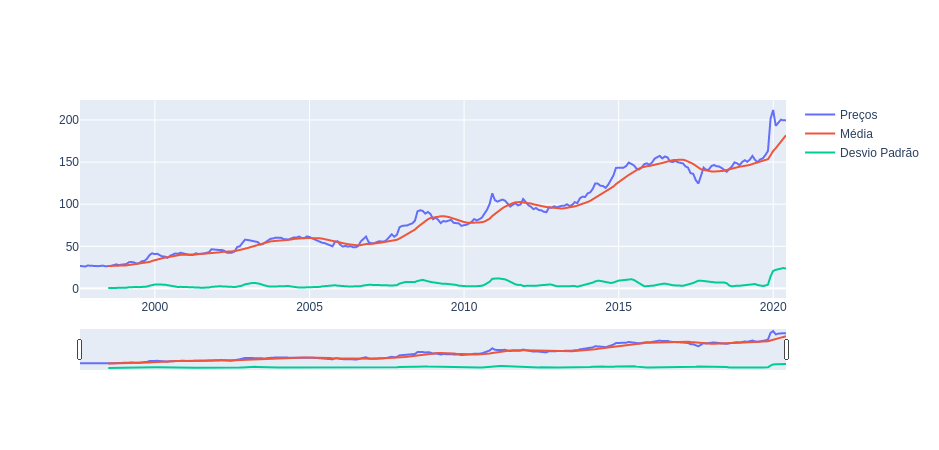


Resultado do Teste Dickey-Fuller:

Estatística do Teste              0.876994
Valor-p                           0.992783
Número de Lags Consideradas       7.000000
Número de Observações Usadas    267.000000
Valor Crítico (1%)               -3.455081
Valor Crítico (5%)               -2.872427
Valor Crítico (10%)              -2.572571
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.

Resultado do KPPS:

Estatística do Teste            1.666622
Valor-p                         0.010000
Número de Lags Consideradas    16.000000
Valor Crítico (10%)             0.347000
Valor Crítico (5%)              0.463000
Valor Crítico (2.5%)            0.574000
Valor Crítico (1%)              0.739000
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [19]:
# Aplica os testes ADF e KPSS e plota o gráfico dos preços com as "rolling statistics"
testa_estacionaridade(bg)

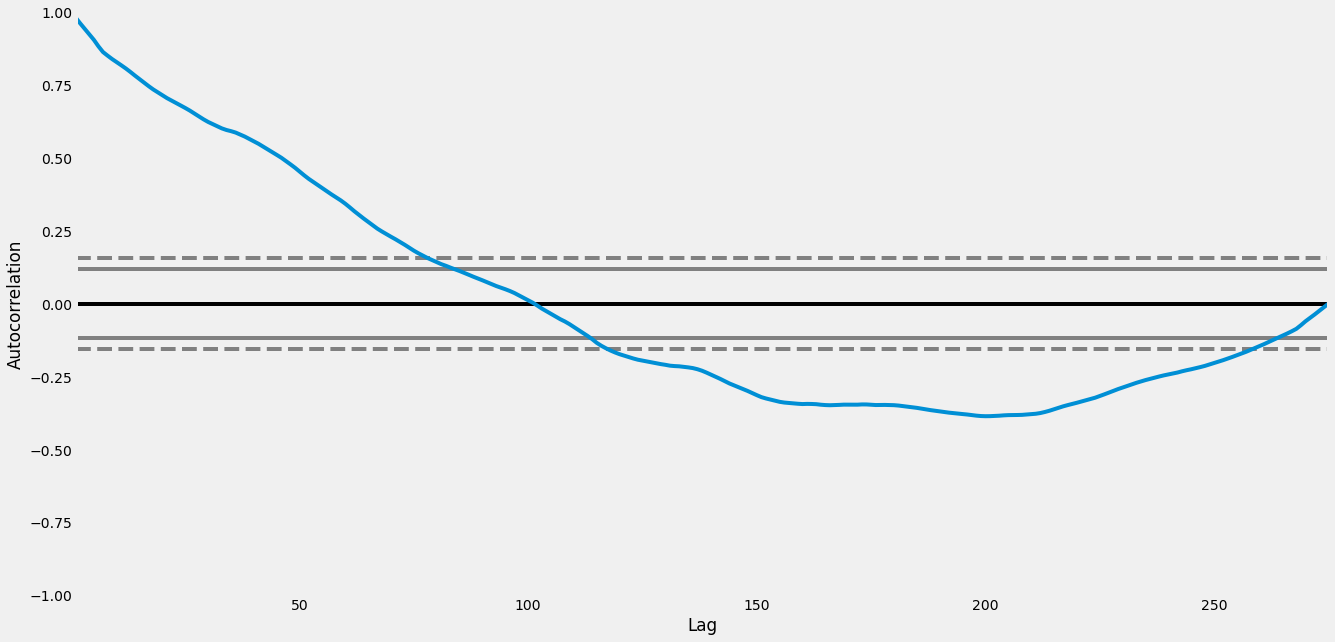

In [20]:
# Cria o gráfico de autocorrelação para séries temporais
autocorrelation_plot(bg)

# Plota o gráfico
plt.show()

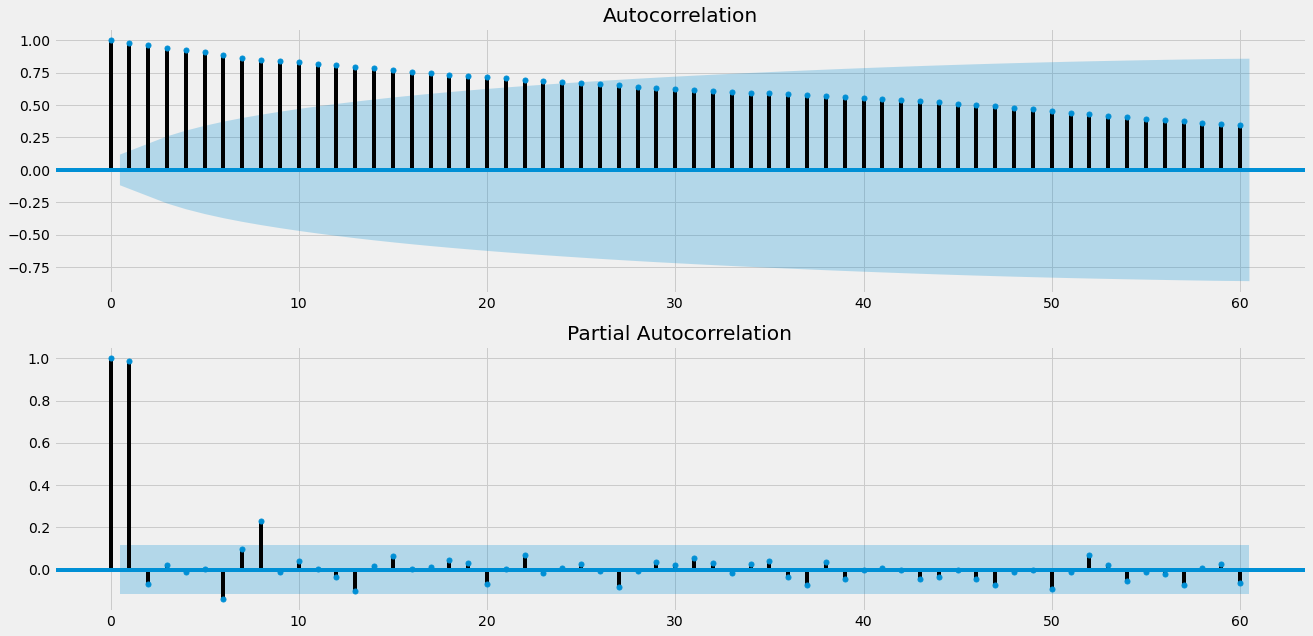

In [21]:
# Plot do gráfico ACF
plt.subplot(211)
plot_acf(bg, ax=plt.gca(), lags=60)

# Plot do gráfico PACF
plt.subplot(212)
plot_pacf(bg, ax=plt.gca(), lags=60)

# Mostra os gráficos
plt.show()

No gráfico, o eixo vertical indica a autocorrelação e o horizontal a defasagem. A área sombreada em azul indica onde é significativamente diferente de zero. Como é possível ver na imagem, temos **diversos valores ACF (barras verticais) acima do limite da área sombreada em azul**. Nesses casos, a **autocorrelação é diferente de zero, indicando que a série não é aleatória** – conforme o esperado.

**Algumas barras verticais estão dentro do limite da área sombreada em azul**, Ou seja, a **autocorrelação entre a série com alguns de seus lags é igual a zero, indicando que não há correlação**.

Em termos simples: a área sombreada em azul aponta a significância. Se ultrapassa é porque tem correlação. Cada barra no gráfico ACF representa o nível de correlação entre a série e seus atrasos em ordem cronológica. **A área sombreada em azul indica se o nível de correlação entre a série e cada atraso é significativo ou não**.

Com base na análise visual do gráfico ACF sugere que a série de preços médios do Boi Gordo é não estacionária, o que nos leva ao problema de inferimos a causa e buscar uma maneira de tratar a não estacionárida. Para isso usaremos dois métodos para tornar esta série estacionária para que possamos fazer previsões, estes são:

* **Transformação de Box-Cox**
* **Diferenciação**

### Transformação de Box-Cox

Para tentar tornar a série estacionária a primeira coisa que faremos é uma transformação Box-Cox. Essa transformação consiste em uma maneira de transformar variáveis dependentes **"não normal"** em **normal**. A normalidade é uma suposição importante para muitas técnicas estatísticas; se seus dados não forem normais, a aplicação de um Box-Cox implica que você poderá executar um número mais amplo de testes.

Após feita esta transformação, vamos realizar um novo teste Dickey-Fueller Aumentado e plotar os novos gráficos de autocorrelação para saber se estes dois processos foram removidos.

In [22]:
bg_box, lam_value = boxcox(bg)
print('Valor Ideal de Lambda: %f' % lam_value)
bg_box = pd.Series(bg_box, index=bg.index)
# Visualizando a transformação
bg_box.head()

Valor Ideal de Lambda: 0.184456


Data
1997-07-31    4.516578
1997-08-31    4.494352
1997-09-30    4.467970
1997-10-31    4.547593
1997-11-30    4.524078
Freq: M, dtype: float64

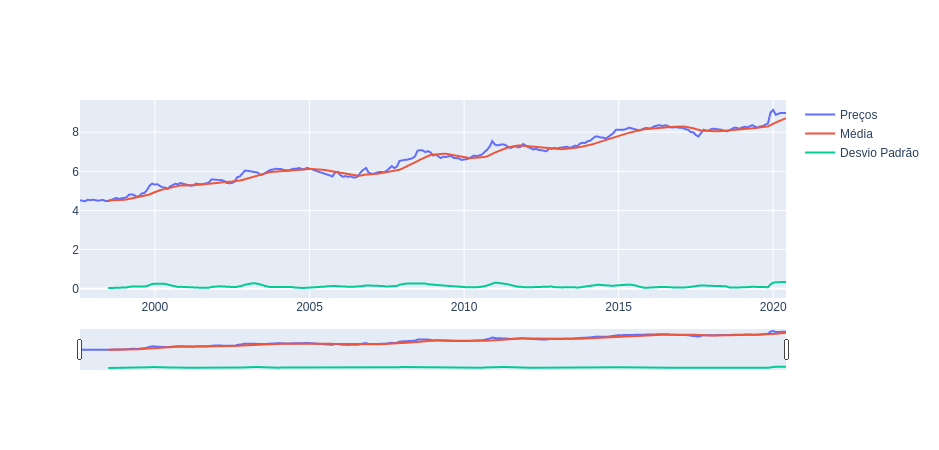


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -0.510177
Valor-p                           0.890015
Número de Lags Consideradas       3.000000
Número de Observações Usadas    271.000000
Valor Crítico (1%)               -3.454713
Valor Crítico (5%)               -2.872265
Valor Crítico (10%)              -2.572485
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.

Resultado do KPPS:

Estatística do Teste            1.691847
Valor-p                         0.010000
Número de Lags Consideradas    16.000000
Valor Crítico (10%)             0.347000
Valor Crítico (5%)              0.463000
Valor Crítico (2.5%)            0.574000
Valor Crítico (1%)              0.739000
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [23]:
testa_estacionaridade(bg_box)

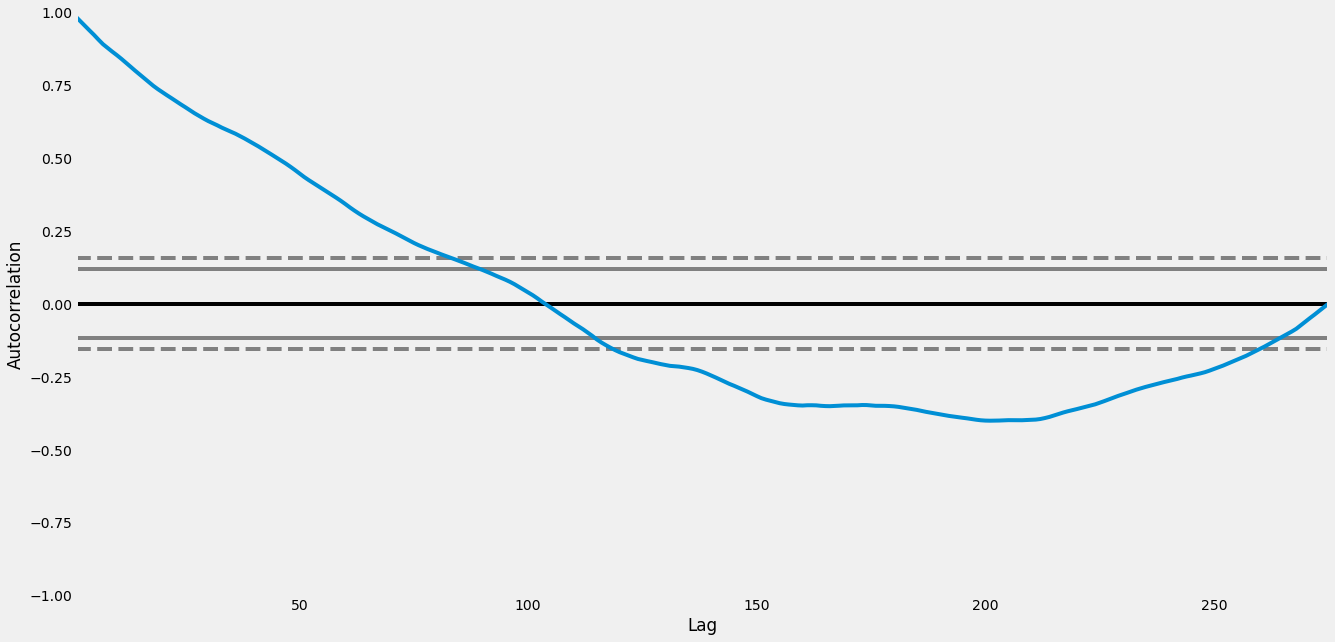

In [24]:
autocorrelation_plot(bg_box)
plt.show()

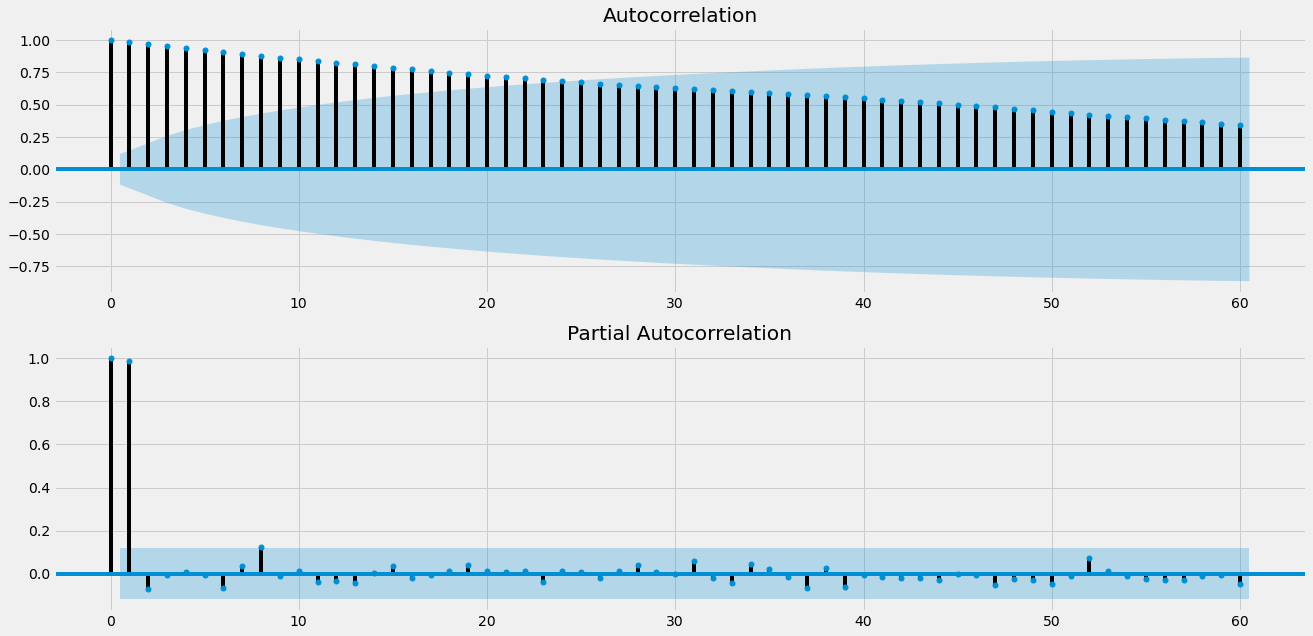

In [25]:
# Plot do gráfico ACF
plt.subplot(211)
plot_acf(bg_box, ax=plt.gca(), lags=60)

# Plot do gráfico PACF
plt.subplot(212)
plot_pacf(bg_box, ax=plt.gca(), lags=60)

# Mostra os gráficos
plt.show()

Com base nos teste de Dickey-Fuller Aumentado e com base nos gráficos da função de autocorrelação somente a transformação de Box-Cox não foi possível transformar a serie histórica de preços do Boi-Gordo em estacionária, assim ainda não e possível poder fazer qualquer previsão com base nestes dados. Para dar sequência vamos agora realizar uma diferenciação de Primeira Ordem.

### Diferenciação

Nesta técnica, tomamos a diferença da observação em um determinado instante com a do instante anterior. A diferenciação é realizada subtraindo a observação anterior da observação atual:

$difference_t = observation_t - observation_{t-1}$

A inversão do processo é necessária quando uma previsão deve ser convertida novamente na escala original. Este processo pode ser revertido adicionando a observação no passo anterior ao valor da diferença.

$inverted_t = differenced_t + observation_{t-1}$

**Ordem da Diferença**

Alguma estrutura temporal ainda pode existir após a execução de uma operação de diferenciação, como no caso de uma tendência não linear.

Como tal, o processo de diferenciação pode ser repetido mais de uma vez até que toda a dependência temporal seja removida. O número de vezes que a diferenciação é realizada é chamado de ordem da diferença. Na primeira diferenciação temos a Diferenciação de Primeira Ordem e assim por diante.

In [26]:
bg_diff = bg_box - bg_box.shift()
bg_diff.dropna(inplace=True)

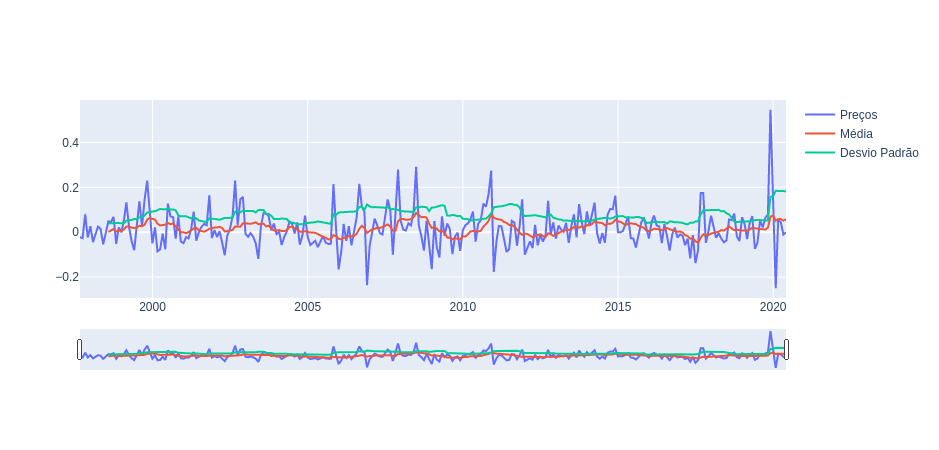


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -8.804961e+00
Valor-p                         2.063694e-14
Número de Lags Consideradas     2.000000e+00
Número de Observações Usadas    2.710000e+02
Valor Crítico (1%)             -3.454713e+00
Valor Crítico (5%)             -2.872265e+00
Valor Crítico (10%)            -2.572485e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.

Resultado do KPPS:

Estatística do Teste            0.034242
Valor-p                         0.100000
Número de Lags Consideradas    16.000000
Valor Crítico (10%)             0.347000
Valor Crítico (5%)              0.463000
Valor Crítico (2.5%)            0.574000
Valor Crítico (1%)              0.739000
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [27]:
testa_estacionaridade(bg_diff)

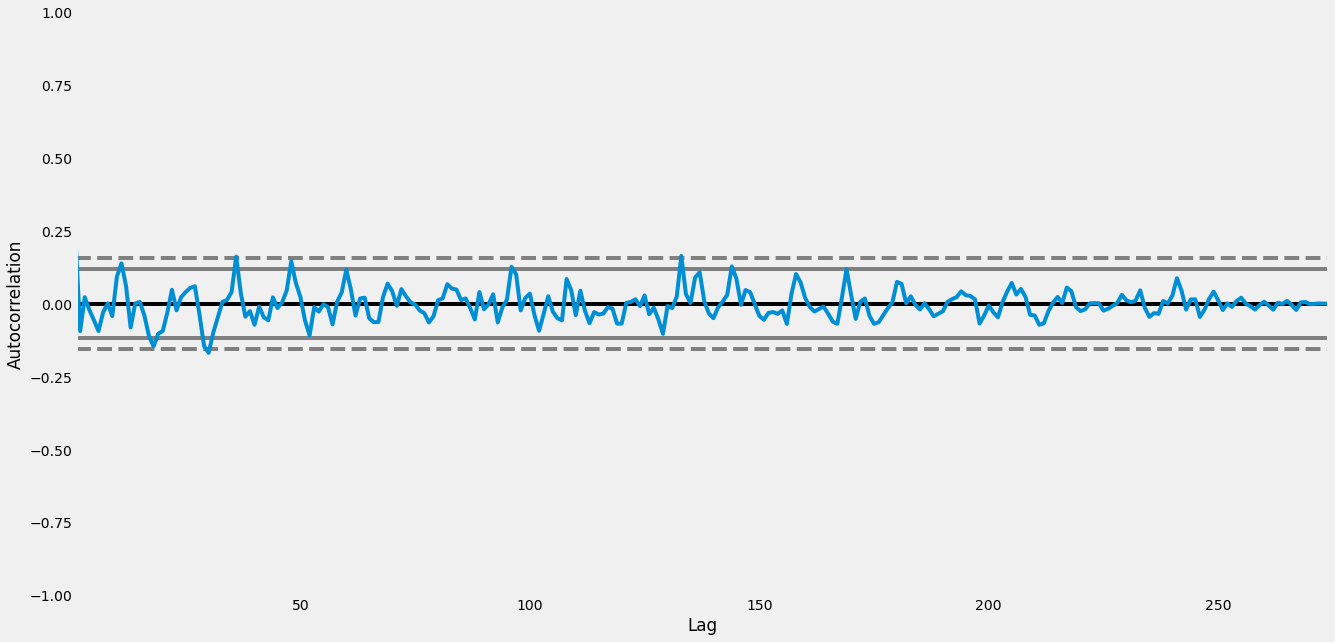

In [28]:
autocorrelation_plot(bg_diff)
plt.show()

In [29]:
# Seleciona a ordem do lag a ser utilizado
data=bg_diff
model=smt.AR(data)
order=smt.AR(data).select_order(ic='aic', maxlag=25)

print('Best lag order = {}'.format(order))

Best lag order = 20


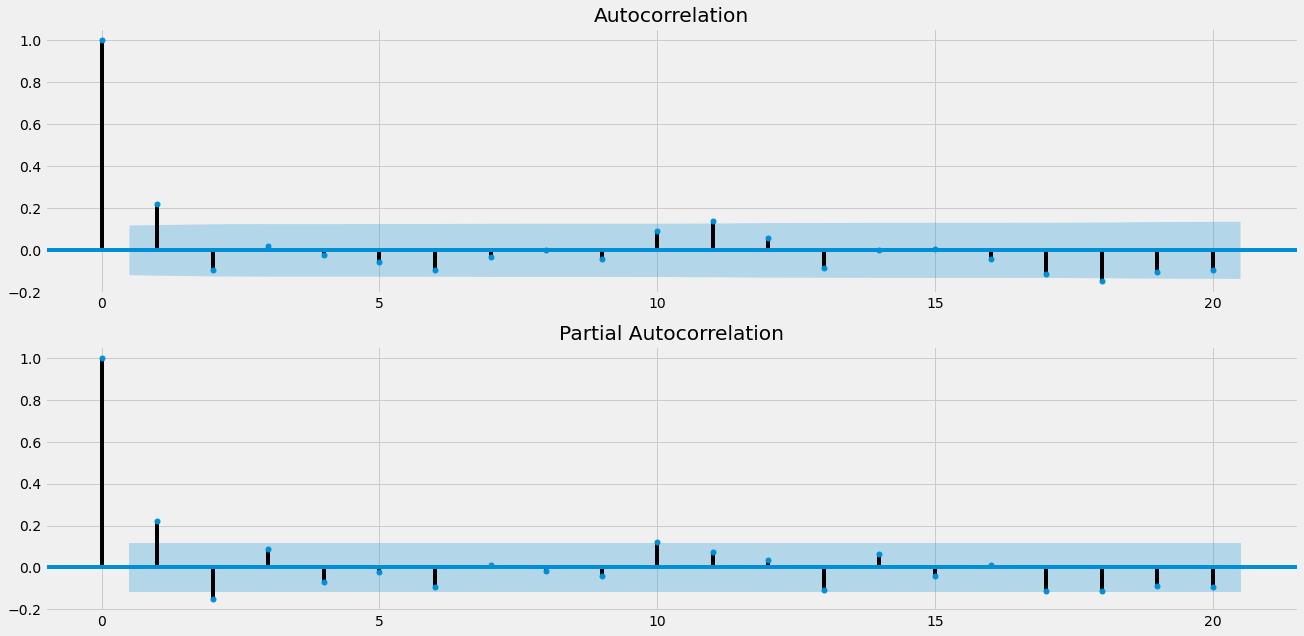

In [30]:
# Plot do gráfico ACF
plt.subplot(211)
plot_acf(bg_diff, ax=plt.gca(), lags=20)

# Plot do gráfico PACF
plt.subplot(212)
plot_pacf(bg_diff, ax=plt.gca(), lags=20)

# Mostra os gráficos
plt.show()

Agora sim, conseguimos transformar a série em uma série estacionaria e remover a autocorrelação que estava presente nos dados até antes da diferenciação. Antes de partir para criação do modelos vamos dividir o conjunto de dados em treino e teste para que possamos avaliar as previsões do modelo quando novos dados são apresentados aos mesmos.

In [31]:
# Função Para o Cálculo da Acurácia
def performace(y_true, y_pred):
    mse = ((y_pred - y_true)**2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return (print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

A Média Móvel Integrada Autoregressiva Sazonal, SARIMA ou ARIMA Sazonal, é uma extensão do ARIMA que suporta explicitamente dados de séries temporais univariadas com um componente sazonal.

Esse modelo adiciona três novos hiperparâmetros para especificar a regressão automática (AR), a diferenciação (I) e a média móvel (MA) para o componente sazonal da série, além de um parâmetro adicional para o período da sazonalidade.

**Elementos de Tendência:**

No modelo SARIMA existem três elementos de tendência que requerem configuração. Eles são iguais ao modelo ARIMA, especificamente:

- $p$: Ordem de regressão automática da tendência.
- $d$: Ordem de diferenciação da tendência.
- $q$: Ordem média móvel de tendência.

**Elementos de Sazonalidade:**

E temos mais quatro elementos sazonais que não fazem parte do ARIMA e que devem ser configurados no modelo SARIMA. Eles são:

- $P$: Ordem autoregressiva sazonal.
- $D$: Ordem da diferença sazonal.
- $Q$: Ordem da média móvel sazonal.
- $m$: O número de etapas de tempo para um único período sazonal. Por exemplo, um S de 12 para dados mensais sugere um ciclo sazonal anual.

**Notação SARIMA:**
Um modelo SARIMA$(p,d,q)(P,D,Q,m)$ é representado da seguinte forma:

$$\begin{align*} 
\phi(L)\Phi(L)\Delta^d\Delta^D = \Theta(L)\Phi(L)\varepsilon_t
\end{align*}$$

Usando um Modelo **Auto-Arima** para retornar os melhores parâmetros de ordem da série, para o menor valor possível da Estatística AIC.

Fazer uma análise manual completa de séries temporais pode ser uma tarefa tediosa, especialmente quando você tem muitos conjuntos de dados para analisar. É preferível automatizar a tarefa de seleção de modelo com a pesquisa em grade (Grid Search). Para o SARIMA, como temos muitos parâmetros, a pesquisa em grade pode levar horas para ser concluída em um conjunto de dados se definirmos o limite de cada parâmetro muito alto. Definir limites muito altos também tornará seu modelo muito complexo e superestimará os dados de treinamento.

Para evitar o longo tempo de execução e o problema de sobreajuste (overfitting), aplicamos o que é conhecido como princípio de parcimônia, onde criamos uma combinação de todos os parâmetros tais que $p + d + q + P + D + Q ≤ 6$. Outra abordagem é definir cada parâmetro como 0 ou 1 ou 2 e fazer a pesquisa na grade usando o **AIC** em cada combinação.

Usaremos a segunda opção, chamada Grid Search Stepwise. Vou definir limites pequenos para os hiperparâmetros, mas você pode testar outros valores se deseja.

In [32]:
# Buscando pela ordem ideal para o modelo
# A função pm.auto_arima aplica o Grid Search e retorna o melhor modelo
model_v1 = pm.auto_arima(bg_box, 
                         seasonal=True, 
                         m=12, 
                         d=1, 
                         D=0, 
                         max_p=3, 
                         max_q=3, 
                         trace=True, 
                         error_action='ignore', 
                         suppress_warnings=True)

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=-600.829, BIC=-571.924, Time=2.033 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=-577.837, BIC=-570.611, Time=0.069 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=-588.522, BIC=-574.070, Time=0.495 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=-594.090, BIC=-579.638, Time=0.573 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=-569.654, BIC=-566.041, Time=0.043 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=-593.123, BIC=-567.831, Time=1.322 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=-593.378, BIC=-568.087, Time=2.049 seconds
Fit ARIMA(2,1,2)x(2,0,1,12) [intercept=True]; AIC=-598.667, BIC=-566.149, Time=6.177 seconds
Fit ARIMA(2,1,2)x(1,0,2,12) [intercept=True]; AIC=-598.502, BIC=-565.984, Time=6.077 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=-593.075, BIC=-571.396, Time=0.595 seconds
Fit ARIMA(2,1,2)x(0,0,2,12

In [33]:
# Sumário do modelo
model_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  275
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 308.524
Date:                              Fri, 29 May 2020   AIC                           -605.048
Time:                                      11:06:30   BIC                           -583.370
Sample:                                           0   HQIC                          -596.347
                                              - 275                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.002      0.616      0.538      -0.002       0.004
ma.L1          0.2695      0.064      4.180      0.000       0.143       0.396
ma.L2         -0.1407      0.047     -2.980      0.003      -0.233      -0.048
ar.S.L12       0.9382      0.087     10.796      0.000       0.768       1.108
ma.S.L12      -0.8584      0.133     -6.478      0.000      -1.118      -0.599
sigma2         0.0061      0.000     22.020      0.000       0.006       0.007
===================================================================================
Ljung-Box (Q):                       34.41   Jarque-Bera (JB):               637.32
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             1.23
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Agora que obtemos as melhores combinações de parâmetros de ordem do modelo podemos treina-lo e assim começar a fazer as nossas previsões para o preço do Boi Gordo.

In [34]:
# Cria o Modelo SARIMA
sarima = sm.tsa.SARIMAX(bg_box, 
                        order=(0, 1, 2), 
                        seasonal_order=(1, 0, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

In [35]:
# Treinamento (Fit) do modelo
result = sarima.fit()

In [36]:
# Sumário do modelo
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  275
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 285.137
Date:                              Fri, 29 May 2020   AIC                           -560.275
Time:                                      11:06:31   BIC                           -542.490
Sample:                                  07-31-1997   HQIC                          -553.124
                                       - 05-31-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2654      0.064      4.167      0.000       0.141       0.390
ma.L2         -0.1502      0.048     -3.101      0.002      -0.245      -0.055
ar.S.L12       0.9061      0.044     20.387      0.000       0.819       0.993
ma.S.L12      -0.8388      0.084    -10.038      0.000      -1.003      -0.675
sigma2         0.0061      0.000     22.838      0.000       0.006       0.007
===================================================================================
Ljung-Box (Q):                       33.12   Jarque-Bera (JB):               711.29
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                             1.26
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A implenetação SARIMAX nos permite testar diversos parâmetros, como tendência, componente sazonal e ruído, para obter o melhor desempenho do modelo. O gráfico PACF representa o valor do decimo oitavo 3 significativamente diferente de zero. 

O valor de $p$ pode ser escolhido como $3$. Para o valor $q$, o ACF representa o primeiro atraso apenas como um valor considerável diferente de zero, mas, para selecionar o melhor da gama de modelos, é possível ajustar SARIMAX a um valor maior, por exemplo, $q$ da faixa (0, 3) Componente sazonal $D = 0$ e parâmetro de diferença $d = 1$. Os parâmetros $Q$ e $P$ serão selecionados com base no melhor modelo da faixa.

### Diagnóstico do Modelo:

Em séries temporais, um dos principais objetivos tende a ser que os **resíduos do nosso modelo não sejam correlacionados e sejam normalmente distribuídos com média zero**. Se esse critério não for atendido é bem provavel que o nosso modelo não seja adequado aos dados e o mesmo pode ser melhorado ainda mais.

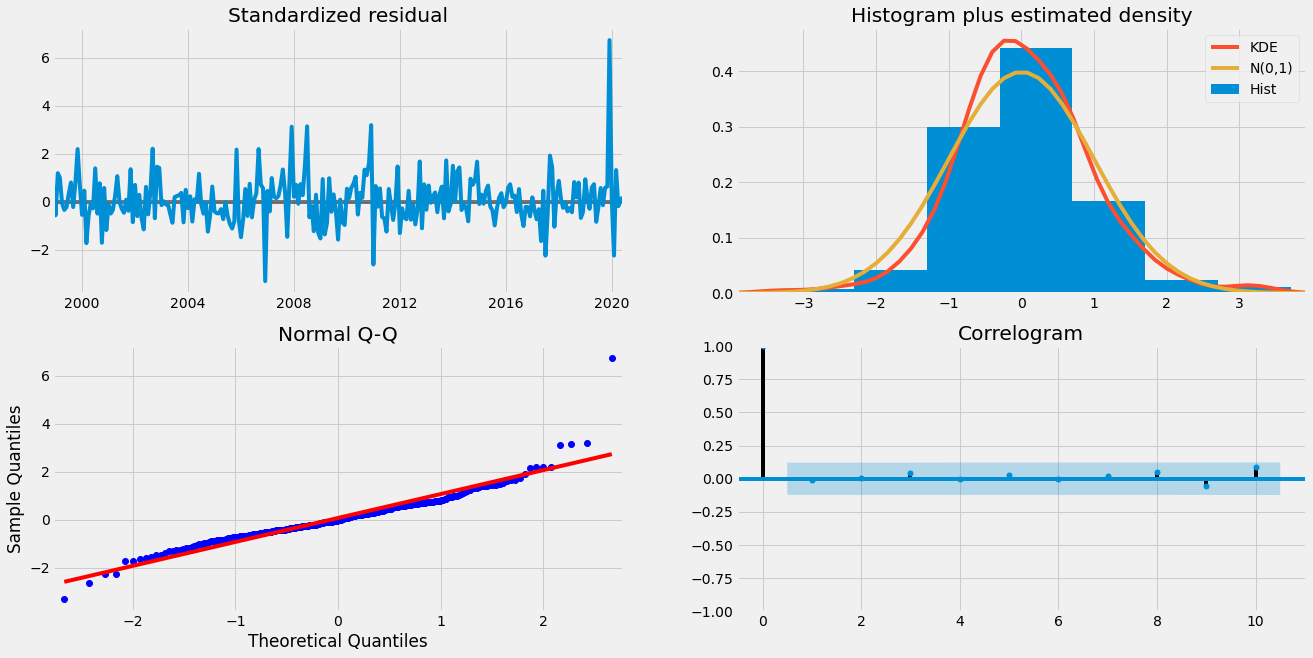

In [37]:
# Diagnóstico do modelo
result.plot_diagnostics()
plt.show()

O diagnóstico do modelo sugere que o resíduo do modelo é normalmente distribuído com base no seguinte:

No gráfico superior direito, a linha vermelha do KDE segue de perto a linha $N(0,1)$. Onde $N(0,1)$ é a notação padrão para uma distribuição normal com média 0 e desvio padrão de 1. **Essa é uma boa indicação de que os resíduos são normalmente distribuídos**.

O gráfico QQ no canto inferior esquerdo mostra que a distribuição ordenada de resíduos (pontos azuis) segue a tendência linear das amostras coletadas de uma distribuição normal padrão, com alguns pequenos outliers. Esta é uma forte indicação de que os resíduos do modelo **SARIMAX(0, 1, 2)(1, 0, 1, 12)** são normalmente distribuídos.

Os resíduos ao longo do tempo (gráfico superior esquerdo) não exibem nenhum padrão óbvio de sazonalidade e parecem ser **ruído branco** (movimentos puramente aleatório). O gráfico de autocorrelação confirma este fato no canto inferior direito, que mostra que os resíduos da série temporal têm baixa correlação com os seus lags.

Agora que temos a certeza que este é um bom modelo para poder prever os preços médios mensais da arroba do boi gordo, vamos fazer algumas previsões com os gráficos para que possamos ver o ajustamento dos preços com as previsões feitas pelo modelo.

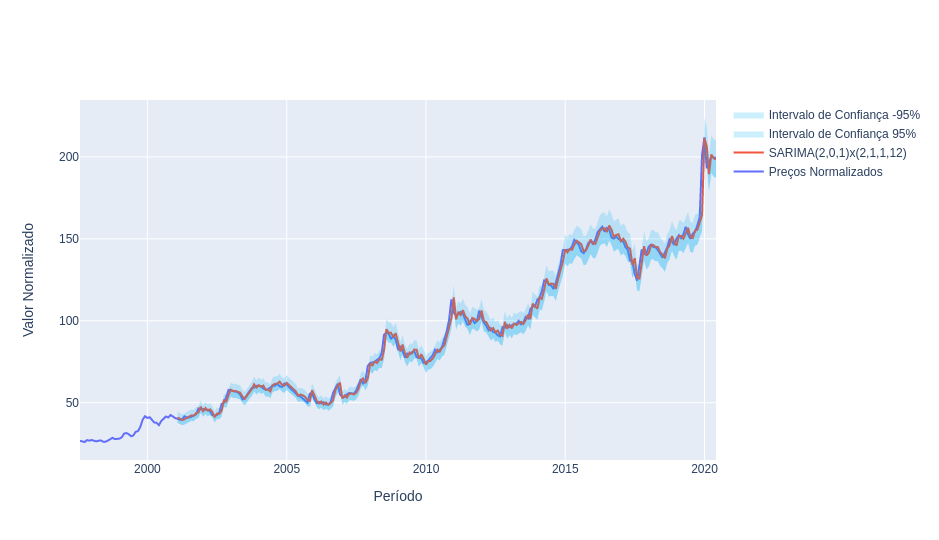

In [38]:
# Plota o gráfico com o ajustamento da curva para o modelo treinado
# Pega as predições a partir do ano de 2001 até o ano 2020
pred = result.get_prediction(start=pd.to_datetime('2001-01-31'), dynamic=False)

# Obtém os intervalos de confiança
pred_ci = inv_boxcox(pred.conf_int(), lam_value)


fig = go.Figure()

# Evolução dos preços do Boi Gordo
fig.add_trace(go.Scatter(x=bg_box.index, 
                         y=inv_boxcox(bg_box, lam_value),
                         mode='lines',
                         fillcolor= 'rgba(0,0,0,1)',
                         name='Preços Normalizados'))

# SARIMA(2,0,1)(2,1,1,12)
fig.add_trace(go.Scatter(x=pred_ci.index,
                         y=inv_boxcox(pred.predicted_mean, lam_value),
                         mode='lines', 
                         name='SARIMA(2,0,1)x(2,1,1,12)'))

# Intervalo de confiança de 95%
fig.add_trace(go.Scatter(x=pred_ci.index, 
                         y=pred_ci.iloc[:, 0], 
                         mode='lines',
                         fill='tonexty', 
                         fillcolor='rgba(0,176,246,0.2)',
                         line_color='rgba(255,255,255,0)',
                         name='Intervalo de Confiança 95%'))

# Intervalo de confiança de -95%
fig.add_trace(go.Scatter(x=pred_ci.index, 
                         y=pred_ci.iloc[:, 1], 
                         mode='lines',
                         fill='tonexty',
                         fillcolor='rgba(0,176,246,0.2)',
                         line_color='rgba(255,255,255,0)',
                         name='Intervalo de Confiança -95%'))

# Define o layout
fig.update_layout(xaxis_title="Período",
                  yaxis_title="Valor Normalizado",
                  width=900, 
                  height=540)

# Plota o gráfico
fig.show()

Como podemos ver os modelo parece se ajustar muito bem aos dados do preços do Boi Gordo, agora ver checar as as métricas referentes ao erro do modelo.

In [39]:
# Obtém os valores das previsões do modelo
y_forecasted = pred.predicted_mean

# Obtém uma amostra do dos dados para o tede
y_truth = bg_box['2014-01-01':]

In [40]:
# Calculando a performance do modelo
sarima_results = performace(bg_box, pred.predicted_mean)
sarima_results

MSE das previsões é 0.01
RMSE das previsões é 0.08
MAPE das previsões é 0.82


As métricas escolhidas também indicam um que o modelo se ajustou muito bem aos dados. Com tudo isso pronto podemos então fazer as previsões para os próximos 12 meses e com isso obter os valores para a arroba do boi gordo para os próximos 12 meses

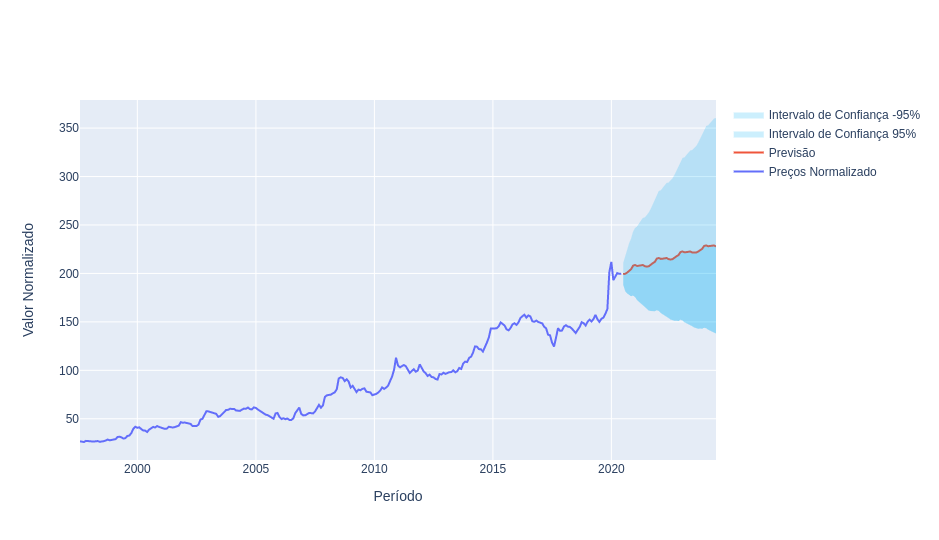

In [41]:
# Plota o gráfico com as previsões um passo a frente
# Pega as previsões um passo a frente a partir de junho 2020 à maio de 2021
pred_uc = result.get_forecast(steps=48)

# Intervalo de confiança das previsões um passo a frente
pred_ci = inv_boxcox(pred_uc.conf_int(), lam_value)

fig = go.Figure()

# Evolução dos preços do Boi Gordo
fig.add_trace(go.Scatter(x=bg_box.index, 
                         y=inv_boxcox(bg_box, lam_value),
                         mode='lines',
                         fillcolor= 'rgba(0,0,0,1)',
                         name='Preços Normalizado'))

# Previsões um passo a frente
fig.add_trace(go.Scatter(x=pred_ci.index,
                         y=inv_boxcox(pred_uc.predicted_mean, lam_value),
                         mode='lines', 
                         name='Previsão'))

# Intervalo de confiança de 95%
fig.add_trace(go.Scatter(x=pred_ci.index, 
                         y=pred_ci.iloc[:, 0], 
                         mode='lines',
                         fill='tonexty', 
                         fillcolor='rgba(0,176,246,0.2)',
                         line_color='rgba(255,255,255,0)',
                         name='Intervalo de Confiança 95%'))

# Intervalo de confiança de -95%
fig.add_trace(go.Scatter(x=pred_ci.index, 
                         y=pred_ci.iloc[:, 1], 
                         mode='lines',
                         fill='tonexty',
                         fillcolor='rgba(0,176,246,0.2)',
                         line_color='rgba(255,255,255,0)',
                         name='Intervalo de Confiança -95%'))

# Define o layout
fig.update_layout(xaxis_title="Período", 
                  yaxis_title="Valor Normalizado", 
                  width=900, 
                  height=540)

# Plota o gráfico
fig.show()

In [42]:
# Salva o resultado das previsões em um DataFrame
forecast2 = pd.DataFrame(inv_boxcox(result.predict(start=pd.to_datetime('2020-05-31'), 
                                                   end=pd.to_datetime('2021-05-31')), 
                                                   lam_value), columns=['Previsto'])
# Visualiza as previsões
forecast2.head(12)

Previsto
2020-05-31  198.409304
2020-06-30  199.303792
2020-07-31  199.587328
2020-08-31  200.863397
2020-09-30  202.978174
2020-10-31  204.372804
2020-11-30  207.979031
2020-12-31  208.723822
2021-01-31  207.673219
2021-02-28  207.904183
2021-03-31  208.479490
2021-04-30  208.673599

Os valores previstos pelo modelo paracem condizentes com a realidade tendo com os maior valores para a arroba do boi gordo durante o último trimestre do ano.

In [43]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(result.resid, lags=[12], boxpierce=False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.00021039]


Com dito no começo deste projeto o mesmo tem a intenção da previsão da média mensal de preços da arroba do boi gordo. Até então o modelo criado se ajusta muito bem aos dados e provável que as suas previsões são consistentes com a realidade, o modelo deve ser monitorado durante os próximos meses para saber o tamanho do erro das previsões. 

Os próximos passos para poder melhorar este trabalho consistem em:

* Utilização da biblioteca Quandl para obtenção dos dados diários da arroba do boi gordo;
* Testar o mesmo modelo nos contratos futuros de boi gordo da B3;
* Testar o modelo SARIMAX com variaveis exógenas;
* Testar outros modelos que possam obter uma menor erro do que o atual ex: Facebook Prophet, LSTM, DeepAR;
* Deploy do modelo.